In [535]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import random

Загрузим данные сервиса доставки заказов.

In [536]:
df = pd.read_csv("delivery_service_data_.csv")
df.head()

,user_id,fname,sname,gender,age,address,phone,email,is_suspicious,card_usage,cash_usage,count_cancelations,count_order_creations,first_order_date,last_order_date
0,1,Иларион,Маслов,M,45,"д. Гудермес, ш. Заливное, д. 1 стр. 3/3, 634266",8 (428) 507-03-12,luchezar_65@example.org,False,0.0,3.0,1.0,2.0,2014-07-13,2017-11-30
1,2,Лаврентий,Мясников,M,17,"п. Тутончаны, бул. Павлова, д. 66 стр. 3/4, 93...",+71876956020,artemi_2014@example.net,True,1.0,2.0,13.0,17.0,2015-01-20,2024-03-29
2,3,Станислав,Мартынов,F,42,"клх Шуя, пер. Угловой, д. 86 стр. 745, 908917",8 (355) 315-8905,panfilovaevdokija@example.com,False,2.0,0.0,1.0,1.0,2015-02-02,2015-02-02
3,4,Тит,Мамонтов,F,18,"п. Змеиногорск, ул. Майская, д. 73 к. 8/2, 612907",8 (229) 802-4199,ija43@example.com,True,4.0,2.0,15.0,19.0,2005-09-25,2023-12-05
4,5,Нифонт,Смирнов,F,22,"г. Петропавловск-Камчатский, ул. Сахалинская, ...",8 528 417 87 57,danilovmstislav@example.org,False,2.0,1.0,1.0,2.0,2008-02-21,2012-02-26


Посмотрим на типы данных нашего датасета и на наличие пропусков.

In [537]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                5000 non-null   int64  
 1   fname                  5000 non-null   object 
 2   sname                  5000 non-null   object 
 3   gender                 5000 non-null   object 
 4   age                    5000 non-null   int64  
 5   address                5000 non-null   object 
 6   phone                  5000 non-null   object 
 7   email                  5000 non-null   object 
 8   is_suspicious          5000 non-null   bool   
 9   card_usage             5000 non-null   float64
 10  cash_usage             5000 non-null   float64
 11  count_cancelations     5000 non-null   float64
 12  count_order_creations  5000 non-null   float64
 13  first_order_date       4335 non-null   object 
 14  last_order_date        4335 non-null   object 
dtypes: b

Выведем описательные статистики для нашего датасета.

In [538]:
df.describe()

,user_id,age,card_usage,cash_usage,count_cancelations,count_order_creations
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,31.077200,1.316000,1.36340,5.454800,8.755000
std,1443.520003,8.347813,1.391737,1.40831,5.536324,7.613919
min,1.000000,17.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,24.000000,0.000000,0.00000,0.000000,2.000000
50%,2500.500000,31.000000,1.000000,1.00000,2.000000,4.000000
75%,3750.250000,38.000000,2.000000,2.00000,11.000000,17.000000
max,5000.000000,45.000000,11.000000,9.00000,17.000000,23.000000


Добавим новые признаки такие как: количество цифр в email, разнцу между первым и последним заказом в днях. А также закодируем категориальную переменную gender.

In [539]:
def count_digits(x):
    x = list(x)
    counter = 0
    for ch in x:
        if ch.isdigit():
            counter += 1
    return counter

df["number_digits_in_email"] = df["email"].apply(lambda w: count_digits(w))
df.head()

,user_id,fname,sname,gender,age,address,phone,email,is_suspicious,card_usage,cash_usage,count_cancelations,count_order_creations,first_order_date,last_order_date,number_digits_in_email
0,1,Иларион,Маслов,M,45,"д. Гудермес, ш. Заливное, д. 1 стр. 3/3, 634266",8 (428) 507-03-12,luchezar_65@example.org,False,0.0,3.0,1.0,2.0,2014-07-13,2017-11-30,2
1,2,Лаврентий,Мясников,M,17,"п. Тутончаны, бул. Павлова, д. 66 стр. 3/4, 93...",+71876956020,artemi_2014@example.net,True,1.0,2.0,13.0,17.0,2015-01-20,2024-03-29,4
2,3,Станислав,Мартынов,F,42,"клх Шуя, пер. Угловой, д. 86 стр. 745, 908917",8 (355) 315-8905,panfilovaevdokija@example.com,False,2.0,0.0,1.0,1.0,2015-02-02,2015-02-02,0
3,4,Тит,Мамонтов,F,18,"п. Змеиногорск, ул. Майская, д. 73 к. 8/2, 612907",8 (229) 802-4199,ija43@example.com,True,4.0,2.0,15.0,19.0,2005-09-25,2023-12-05,2
4,5,Нифонт,Смирнов,F,22,"г. Петропавловск-Камчатский, ул. Сахалинская, ...",8 528 417 87 57,danilovmstislav@example.org,False,2.0,1.0,1.0,2.0,2008-02-21,2012-02-26,0


In [540]:
df["first_order_date"] = pd.to_datetime(df[df["first_order_date"] != 0]["first_order_date"], format='%Y-%m-%d')
df["last_order_date"] = pd.to_datetime(df[df["last_order_date"] != 0]["last_order_date"], format='%Y-%m-%d')
df["days_between_first_and_last_orders"] = (df["last_order_date"] - df["first_order_date"]).dt.days
df.head()

,user_id,fname,sname,gender,age,address,phone,email,is_suspicious,card_usage,cash_usage,count_cancelations,count_order_creations,first_order_date,last_order_date,number_digits_in_email,days_between_first_and_last_orders
0,1,Иларион,Маслов,M,45,"д. Гудермес, ш. Заливное, д. 1 стр. 3/3, 634266",8 (428) 507-03-12,luchezar_65@example.org,False,0.0,3.0,1.0,2.0,2014-07-13,2017-11-30,2,1236.0
1,2,Лаврентий,Мясников,M,17,"п. Тутончаны, бул. Павлова, д. 66 стр. 3/4, 93...",+71876956020,artemi_2014@example.net,True,1.0,2.0,13.0,17.0,2015-01-20,2024-03-29,4,3356.0
2,3,Станислав,Мартынов,F,42,"клх Шуя, пер. Угловой, д. 86 стр. 745, 908917",8 (355) 315-8905,panfilovaevdokija@example.com,False,2.0,0.0,1.0,1.0,2015-02-02,2015-02-02,0,0.0
3,4,Тит,Мамонтов,F,18,"п. Змеиногорск, ул. Майская, д. 73 к. 8/2, 612907",8 (229) 802-4199,ija43@example.com,True,4.0,2.0,15.0,19.0,2005-09-25,2023-12-05,2,6645.0
4,5,Нифонт,Смирнов,F,22,"г. Петропавловск-Камчатский, ул. Сахалинская, ...",8 528 417 87 57,danilovmstislav@example.org,False,2.0,1.0,1.0,2.0,2008-02-21,2012-02-26,0,1466.0


In [541]:
df["DecodeGender"] = df["gender"].map({"M": 1, "F": 0})
df.head()

,user_id,fname,sname,gender,age,address,phone,email,is_suspicious,card_usage,cash_usage,count_cancelations,count_order_creations,first_order_date,last_order_date,number_digits_in_email,days_between_first_and_last_orders,DecodeGender
0,1,Иларион,Маслов,M,45,"д. Гудермес, ш. Заливное, д. 1 стр. 3/3, 634266",8 (428) 507-03-12,luchezar_65@example.org,False,0.0,3.0,1.0,2.0,2014-07-13,2017-11-30,2,1236.0,1
1,2,Лаврентий,Мясников,M,17,"п. Тутончаны, бул. Павлова, д. 66 стр. 3/4, 93...",+71876956020,artemi_2014@example.net,True,1.0,2.0,13.0,17.0,2015-01-20,2024-03-29,4,3356.0,1
2,3,Станислав,Мартынов,F,42,"клх Шуя, пер. Угловой, д. 86 стр. 745, 908917",8 (355) 315-8905,panfilovaevdokija@example.com,False,2.0,0.0,1.0,1.0,2015-02-02,2015-02-02,0,0.0,0
3,4,Тит,Мамонтов,F,18,"п. Змеиногорск, ул. Майская, д. 73 к. 8/2, 612907",8 (229) 802-4199,ija43@example.com,True,4.0,2.0,15.0,19.0,2005-09-25,2023-12-05,2,6645.0,0
4,5,Нифонт,Смирнов,F,22,"г. Петропавловск-Камчатский, ул. Сахалинская, ...",8 528 417 87 57,danilovmstislav@example.org,False,2.0,1.0,1.0,2.0,2008-02-21,2012-02-26,0,1466.0,0


Уберем ненужные признаки

In [542]:
data = df.drop(["user_id", "fname", "sname", "address", "phone", "email", "is_suspicious", "gender", "first_order_date", "last_order_date"], axis=1)
data.head()

,age,card_usage,cash_usage,count_cancelations,count_order_creations,number_digits_in_email,days_between_first_and_last_orders,DecodeGender
0,45,0.0,3.0,1.0,2.0,2,1236.0,1
1,17,1.0,2.0,13.0,17.0,4,3356.0,1
2,42,2.0,0.0,1.0,1.0,0,0.0,0
3,18,4.0,2.0,15.0,19.0,2,6645.0,0
4,22,2.0,1.0,1.0,2.0,0,1466.0,0


In [543]:
data.isna().sum()

age                                     0
card_usage                              0
cash_usage                              0
count_cancelations                      0
count_order_creations                   0
number_digits_in_email                  0
days_between_first_and_last_orders    665
DecodeGender                            0
dtype: int64

In [544]:
data = data.fillna(0)

In [545]:
data.isna().sum()

age                                   0
card_usage                            0
cash_usage                            0
count_cancelations                    0
count_order_creations                 0
number_digits_in_email                0
days_between_first_and_last_orders    0
DecodeGender                          0
dtype: int64

In [546]:
data.describe()

,age,card_usage,cash_usage,count_cancelations,count_order_creations,number_digits_in_email,days_between_first_and_last_orders,DecodeGender
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,31.077200,1.316000,1.36340,5.454800,8.755000,1.323600,1949.966800,0.507600
std,8.347813,1.391737,1.40831,5.536324,7.613919,1.621792,2154.481369,0.499992
min,17.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,0.00000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,31.000000,1.000000,1.00000,2.000000,4.000000,0.000000,1104.500000,1.000000
75%,38.000000,2.000000,2.00000,11.000000,17.000000,2.000000,3747.750000,1.000000
max,45.000000,11.000000,9.00000,17.000000,23.000000,4.000000,7253.000000,1.000000


In [563]:
target = df.is_suspicious
target.head()

0    False
1     True
2    False
3     True
4    False
Name: is_suspicious, dtype: bool

Построим baseline модель. Сначала разделим выборку на тестовую и тренировочную.

In [564]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.4, random_state = 42)

In [565]:
baseline = RandomForestClassifier()
baseline.fit(X_train, y_train)
preds = baseline.predict(X_test)

In [566]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.76      0.85      0.81       661
        True       0.92      0.87      0.90      1339

    accuracy                           0.86      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.87      0.86      0.87      2000



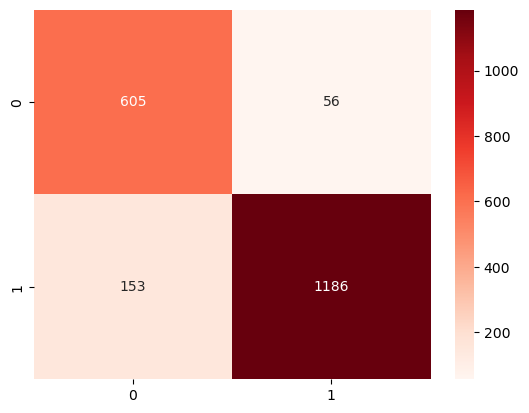

In [574]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Reds');

Метрики качества показывают, что модель нередко определяет клиента, не являющегося подозрительным, за подозрительного. Возможно в тренировочной выборке существует дизбаланс классов, и из-за этого модель ошибается в классификации клиентов, не являющихся подозрительными.

In [575]:
preds = baseline.predict(X_train)

In [576]:
print(classification_report(y_train, preds))

              precision    recall  f1-score   support

       False       0.95      0.98      0.96      1070
        True       0.99      0.97      0.98      1930

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



Попробуем улучшить метрики путем подбора гиперпараметров для модели классификации с помощью RandomSearch.

In [570]:
grid = {
    'n_estimators': list(range(10, 100, 5)),
    'max_features': list(range(1, X_train.shape[1] + 1)),
    'min_samples_leaf': list(range(1, 15))
}

In [571]:
clf = RandomizedSearchCV(baseline, grid, random_state=42)
search = clf.fit(X_train, y_train)

In [572]:
search.best_params_

{'n_estimators': 15, 'min_samples_leaf': 12, 'max_features': 6}

In [573]:
model = RandomForestClassifier(n_estimators=80, min_samples_leaf=12, max_features=7,)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.80      0.92      0.85       661
        True       0.95      0.89      0.92      1339

    accuracy                           0.90      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.90      0.90      0.90      2000



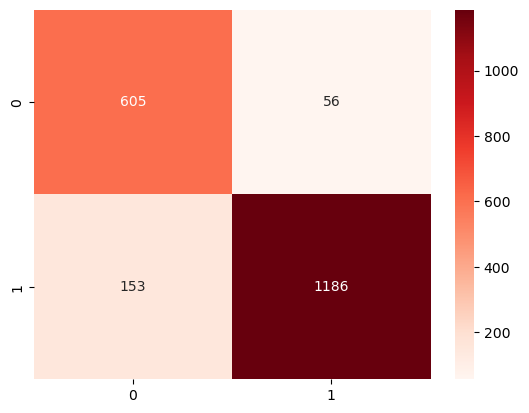

In [561]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Reds');

Метрики немного улучшились: accuracy подросла на 0,04, но нас больше интересует метрика f1 - она выросла также на 0,04 для класса 0 и на 0,02 для класса 1.